# Visualize the underlying image/genetic patterns of some features

In [2]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

import torch

# Self-defined functions
from utils_data import normalize, augmentor

# Grad-CAM
sys.path.append("../../GradCAM")

# 1) Load data

In [3]:
gene_stat = pd.read_csv("../data/BC_gene_set_count_stats.csv", index_col=0)
cols = ["coords"]
cols.extend(gene_stat.columns.values)
image_dict = dict()
position_dict = dict()
image_feature = []
gene_feature = []
image_feature_naive = []
count_created = False
for image_id in np.arange(2, 5):
    _image_dict = torch.load("../../spatial_transcriptomics/data/image_HE_layer{}_BC_dict.pt".format(image_id))
    _count = pd.read_csv("../data/HE_layer{}_BC_count.csv".format(image_id), usecols=cols)
    
    # Update index
    _image_dict = dict(zip(["{}_{}".format(image_id, _) for _ in _image_dict.keys()], _image_dict.values()))
    image_dict.update(_image_dict)
    
    _count.loc[:, "coords"] = ["{}_{}".format(image_id, _) for _ in _count.loc[:, "coords"].values]
    _count = _count.set_index("coords")
    
    # Load feature outputs and position_dict
    _indexes = list(set(_image_dict.keys()) & set(_count.index.values))
    _indexes.sort()
    _image_feature, _gene_feature, _image_feature_naive, _, _position_dict, color_dict = \
        torch.load(os.path.join("../data", "image_HE_layer{}_BC_features.pt".format(image_id)))
    image_feature.extend(_image_feature)
    gene_feature.extend(_gene_feature)
    image_feature_naive.extend(_image_feature_naive)
    for key in list(_position_dict.keys()):
        if key not in position_dict.keys():
            position_dict[key] = [_indexes[_] for _ in _position_dict[key]]
        else:
            position_dict[key].extend([_indexes[_] for _ in _position_dict[key]])
    
    if count_created:
        count = pd.concat([count, _count])
    else:
        count = _count
        count_created = True

In [4]:
# log2
count = np.log2(count + 1)

# Normalize gene_stat by divided with max
tile_95 = np.log2(gene_stat.loc['max', :].values + 1)
tile_95[tile_95 < 1] = 1
count = count/tile_95

# Get indexes for each image/count point
indexes = list(set(image_dict.keys()) & set(count.index.values))
indexes.sort()
print("# of samples: {}".format(len(indexes)))

image_mean = np.array([149.91262888, 125.60738922, 155.41683322])
image_std = np.array([64.47969016, 65.98274776, 53.71798459])

# of samples: 777


In [5]:
for key in list(position_dict.keys()):
    print("{}: {}".format(key, position_dict[key]))

1: ['2_27.002x11.945', '2_27.013x12.96', '2_26.982x13.977', '2_27.973x13.971', '2_26.999x14.966', '2_27.865x14.971', '2_27.004x15.931', '2_27.94x15.929', '2_28.956x15.926', '3_9.894x23.009', '3_10.93x22.914', '3_12.124x23.068', '3_9.911x23.982', '3_10.889x23.881', '3_10.9x10.966', '3_13.091x24.002', '3_13.174x25.027', '4_10.792x19.839', '4_12.007x18.987', '4_11.997x20.052', '4_13.012x20.038', '4_11.982x21.037', '4_12.985x20.966', '4_12.935x22.01', '4_13.979x21.994', '4_14.92x22.998']
2: ['2_24.038x11.933', '2_24.959x11.972', '2_24.06x12.946', '2_24.93x12.97', '2_20.925x23.924', '2_24.967x13.956', '2_24.985x14.951', '3_13.016x22.024', '3_14.067x22.016', '3_15.018x23.031', '3_16.036x23.024', '3_16.095x23.98', '4_15.903x21.999']
3: ['2_20.869x15.941', '2_19.898x16.997', '2_20.946x16.93', '2_18.92x17.932', '2_19.947x17.924', '3_15.03x15.989', '3_14.987x17.052']
4: ['2_14.936x17.987', '3_17.966x11.997', '4_23.077x13.96', '4_24.067x13.942']
5: ['2_10.825x16.832', '2_11.987x15.985', '2_12.005

In [6]:
# Combine to a big numpy matrix
image_feature = np.array([_.numpy() for _ in image_feature])
gene_feature = np.array([_.numpy() for _ in gene_feature])
image_feature_naive = np.array([_.numpy() for _ in image_feature_naive])

# Normalize
image_feature = image_feature/(np.sum(image_feature**2, axis=1, keepdims=True)**0.5)
gene_feature = gene_feature/(np.sum(gene_feature**2, axis=1, keepdims=True)**0.5)
image_feature_naive = image_feature_naive/(np.sum(image_feature_naive**2, axis=1, keepdims=True)**0.5)

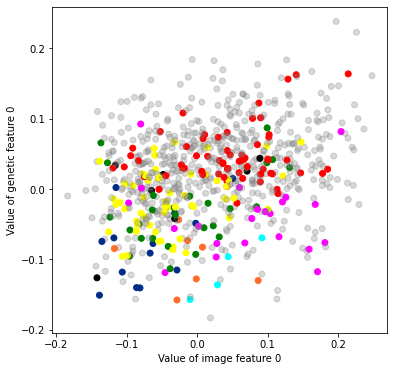

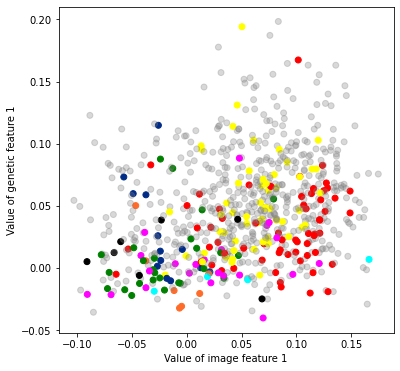

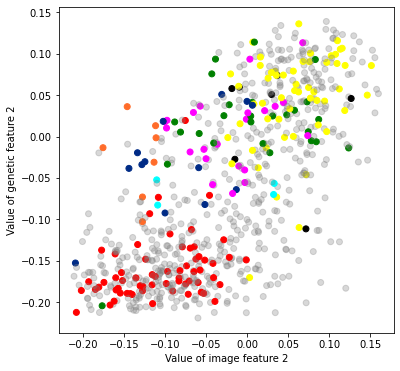

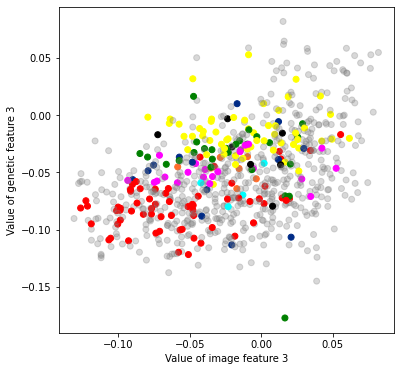

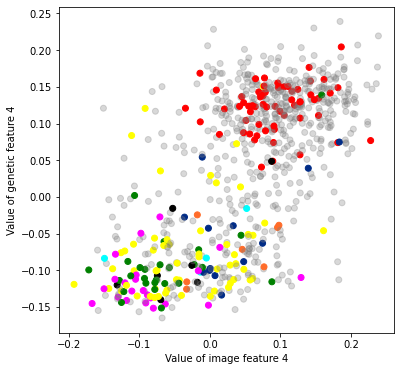

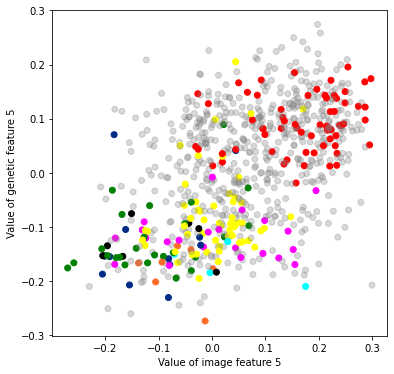

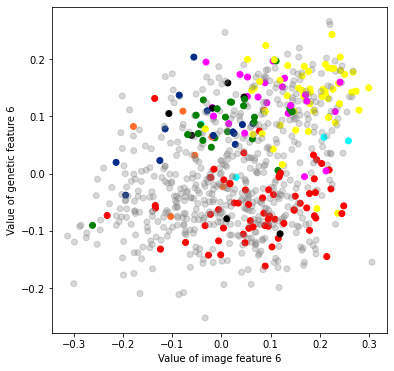

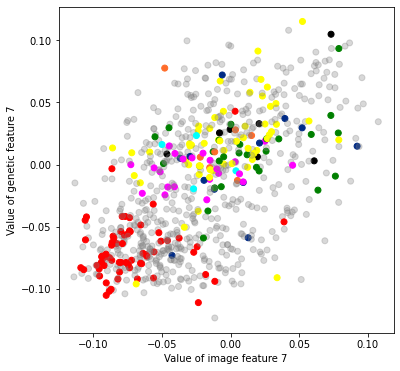

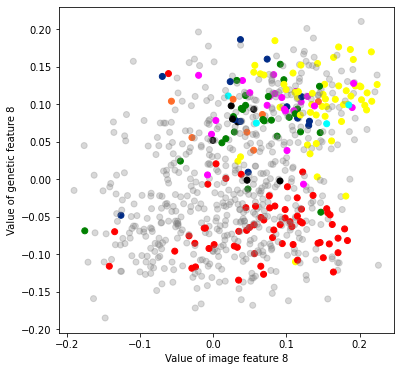

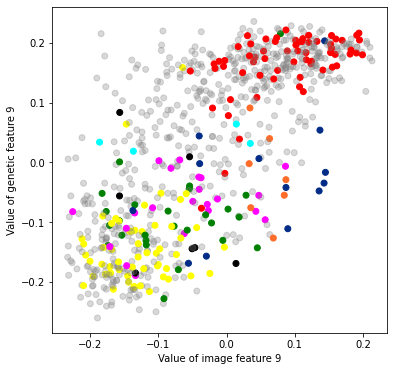

In [7]:
# Create position and color vector
n = len(image_feature)
mycolor = [[0.5, 0.5, 0.5, 0.3]] * n
group = [-1] * n
for i in range(n):
    for key in list(position_dict.keys()):
        for _ in position_dict[key]:
            if indexes[i] == _:
                mycolor[i] = color_dict[key]
                group[i] = key

# Scatter plot
for feature_id in range(10):
    plt.figure(figsize=(6, 6))
    plt.scatter(image_feature[:, feature_id], gene_feature[:, feature_id], c=mycolor)
    plt.xlabel("Value of image feature {}".format(feature_id))
    plt.ylabel("Value of genetic feature {}".format(feature_id))
    plt.show()

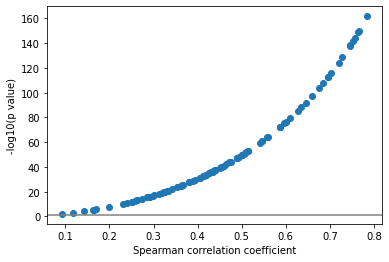

0, corr: 0.263, pv: 8.414744875482719e-14
1, corr: 0.258, pv: 2.5603569661163585e-13
2, corr: 0.695, pv: 2.671040801856488e-113
3, corr: 0.44, pv: 3.3633603063462215e-38
4, corr: 0.597, pv: 3.9310929744552645e-76
5, corr: 0.465, pv: 7.454503063331685e-43
6, corr: 0.343, pv: 8.152159615332798e-23
7, corr: 0.559, pv: 4.2265997365953376e-65
8, corr: 0.333, pv: 1.3840459387091606e-21
9, corr: 0.745, pv: 1.1062562422436945e-138
10, corr: 0.545, pv: 1.9509933595764108e-61
11, corr: 0.414, pv: 1.440381344890093e-33
12, corr: 0.5, pv: 2.3027554271713143e-50
13, corr: 0.475, pv: 5.681792011256539e-45
14, corr: 0.273, pv: 8.854712318200302e-15
15, corr: 0.66, pv: 2.7038972191554904e-98
16, corr: 0.42, pv: 1.7518547952112373e-34
17, corr: 0.588, pv: 2.2470546497596852e-73
18, corr: 0.232, pv: 6.349665841228932e-11
19, corr: 0.361, pv: 2.180345681082589e-25
20, corr: 0.389, pv: 1.622828887604981e-29
21, corr: 0.49, pv: 2.833410690212637e-48
22, corr: 0.747, pv: 2.3636847820753114e-139
23, corr: 0.

In [8]:
# Correlation coef.
from scipy.stats import spearmanr

corr = []
pv = []

n_out_features = 100

for i in range(n_out_features):
    corr_res = spearmanr(image_feature[:, i], gene_feature[:, i])
    corr.append(corr_res.correlation)
    pv.append(corr_res.pvalue)
    
plt.scatter(corr, -np.log10(pv))
plt.xlabel("Spearman correlation coefficient")
plt.ylabel("-log10(p value)")
plt.axhline(-np.log10(0.05), color="gray")
plt.show()

for i in range(n_out_features):
    print("{}, corr: {}, pv: {}".format(i, np.round(corr[i], 3), pv[i]))

# 2) Load model

In [9]:
from utils_eval import NCESoftmaxLoss, NCECriterion
from IGCmodel import IGCNet, NCEAverage

# device = torch.device(0)
device = 'cpu'
image_shape = image_dict[list(image_dict.keys())[0]].shape[0]
n_genes = gene_stat.shape[1]
n_data = 254  # instead of len(indexes) because using different dataset
n_out_features = 100
imagenet = 'resnet101'

# NCE parameters
# Increasing nce_m improves stability
# !!! Adding batch normalization layer improves stability 
nce_k = 100
nce_t = 0.07
nce_m = 0.9
softmax = False

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.001  
momentum = 0.9
weight_decay = 0.0001
gradient_clip = 5

# Set model
model = IGCNet(image_shape=image_shape, n_genes=n_genes, n_out_features=n_out_features, 
               imagenet=imagenet, genenet=[100, 100]).to(device)
contrast = NCEAverage(n_out_features, n_data, nce_k, nce_t, nce_m, softmax, device=device).to(device)
criterion_image = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)
criterion_gene = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)

# Set optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

Using cache found in /home2/swan15/.cache/torch/hub/pytorch_vision_v0.4.0


In [10]:
# Load model
model_file = "./models/IGCNet_02182020/epoch_999.pt"
if model_file is not None:
    print("=> loading checkpoint '{}'".format(model_file))
    checkpoint = torch.load(model_file, map_location=device)
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    contrast.load_state_dict(checkpoint['contrast'])
    del checkpoint

=> loading checkpoint './models/IGCNet_02182020/epoch_999.pt'


In [11]:
model_imagenet = model.imagenet
model_genenet = model.genenet_fcs

# for layer in model_imagenet.children():
#     if isinstance(layer, torch.nn.BatchNorm2d):
#         layer.eval()
def set_eval(layer):
    if hasattr(layer, 'children'):
        for sub_layer in layer.children():
            set_eval(sub_layer)
    if isinstance(layer, torch.nn.BatchNorm2d):
        layer.eval()
set_eval(model_imagenet)
for layer in model_genenet.children():
    if isinstance(layer, torch.nn.BatchNorm1d):
        layer.eval()

model_imagenet = model_imagenet.to(device)
model_genenet = model_genenet.to(device)

## 6) Grad-CAM for images

In [12]:
from grad_cam_IGCNet import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)
import matplotlib.cm as cm

In [13]:
def plot_gradient(gradient, plt=plt):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    plt.imshow(np.uint8(gradient))

def plot_gradcam(gcam, raw_image, paper_cmap=False, plt=plt):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    plt.imshow(np.uint8(gcam))

def plot_sensitivity(maps, plt=plt):
    maps = maps.cpu().numpy()
    scale = max(maps[maps > 0].max(), -maps[maps <= 0].min())
    maps = maps / scale * 0.5
    maps += 0.5
    maps = cm.bwr_r(maps)[..., :3]
    maps = np.uint8(maps * 255.0)
    # maps = cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
    plt.imshow(maps)

	#0: 38 (0.08532)
	#0: 53 (-0.07989)
	#0: 48 (0.08143)
	#0: 95 (0.27006)
	#0: 38 (0.11147)
	#0: 53 (-0.13334)
	#0: 48 (0.13212)
	#0: 95 (0.26910)
	#0: 38 (0.02824)
	#0: 53 (-0.08394)
	#0: 48 (0.10126)
	#0: 95 (0.26098)
	#0: 38 (0.10371)
	#0: 53 (-0.18811)
	#0: 48 (0.09811)
	#0: 95 (0.24464)
	#0: 38 (0.01154)
	#0: 53 (-0.04186)
	#0: 48 (0.15117)
	#0: 95 (0.24306)
	#0: 38 (-0.00978)
	#0: 53 (-0.06103)
	#0: 48 (0.16717)
	#0: 95 (0.23840)
	#0: 38 (0.14087)
	#0: 53 (-0.13104)
	#0: 48 (0.04422)
	#0: 95 (0.23684)
	#0: 38 (0.08958)
	#0: 53 (-0.06884)
	#0: 48 (0.16288)
	#0: 95 (0.23254)
	#0: 38 (0.02279)
	#0: 53 (-0.05471)
	#0: 48 (0.08106)
	#0: 95 (0.23023)
	#0: 38 (0.14637)
	#0: 53 (-0.07579)
	#0: 48 (0.06747)
	#0: 95 (0.22603)
	#0: 38 (0.00374)
	#0: 53 (-0.08601)
	#0: 48 (0.07583)
	#0: 95 (0.22550)
	#0: 38 (0.05056)
	#0: 53 (-0.10740)
	#0: 48 (0.10671)
	#0: 95 (0.22506)
	#0: 38 (0.15444)
	#0: 53 (-0.09544)
	#0: 48 (0.11465)
	#0: 95 (0.22340)
	#0: 38 (-0.03409)
	#0: 53 (-0.12062)
	#0: 48 (0.1

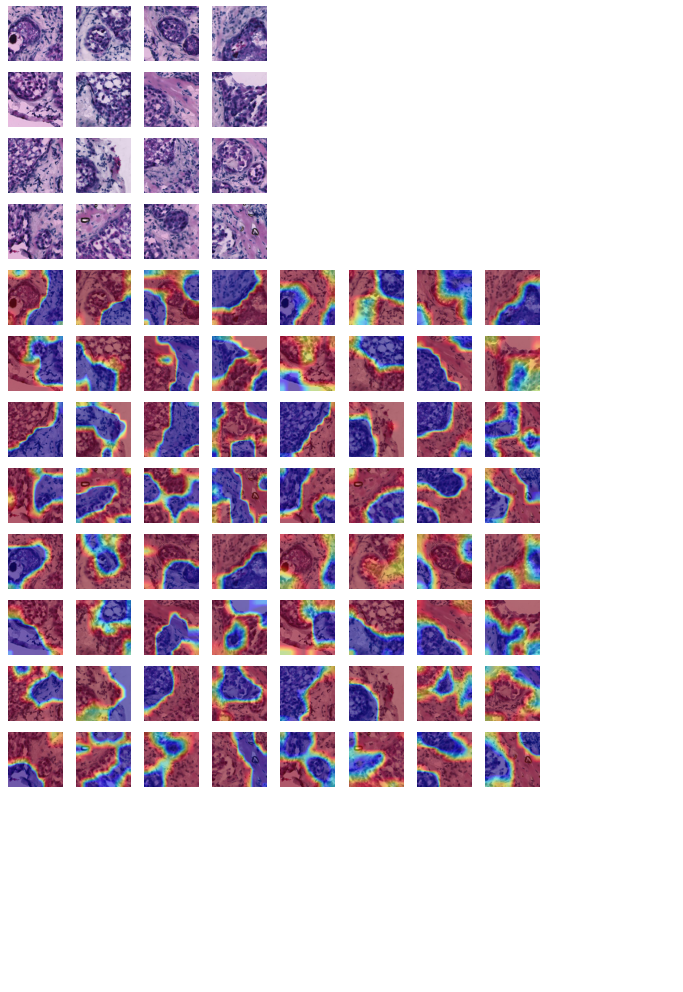

In [15]:
# Select indexes
index_temp = []
i = 95
index_temp.extend(list(np.argsort(image_feature[:, i])[::-1][[0, 1, 2, 6, 7, 8, 9, 12, 13, 15, 16, 17, 18, 22, 31, 33]]))

classes = np.arange(n_out_features)
target_layer = "layer4"

n = 0
fig, axes = plt.subplots(15, 10, figsize=(12, 18))
for n_row in range(4):
    for n_col in range(4):
        # Images
        index = indexes[index_temp[n]]
        image = image_dict[index]
        image_normalized = np.transpose(normalize(image), (2, 0, 1))
        image_normalized = torch.tensor([image_normalized]).float().to(device)

        """
        Common usage:
        1. Wrap your model with visualization classes defined in grad_cam.py
        2. Run forward() with images
        3. Run backward() with a list of specific classes
        4. Run generate() to export results
        """

        '''
        # =========================================================================
        print("Vanilla Backpropagation:")

        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        for i in [38, 53, 48, 95]:
            bp.backward(ids=ids[:, [i]])
            gradients = bp.generate()

            # Plot results
            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        # Remove all the hook function in the "model"
        bp.remove_hook()

        # =========================================================================
        print("Deconvolution:")

        deconv = Deconvnet(model=model_imagenet)
        _ = deconv.forward(image_normalized)

        for i in [38, 53, 48, 95]:
            deconv.backward(ids=ids[:, [i]])
            gradients = deconv.generate()

            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        deconv.remove_hook()
        '''

        # =========================================================================
        # print("Grad-CAM/Guided Backpropagation/Guided Grad-CAM:")
        
        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        gcam = GradCAM(model=model_imagenet)
        _ = gcam.forward(image_normalized)

        # gbp = GuidedBackPropagation(model=model_imagenet)
        # _ = gbp.forward(image_normalized)
        
        axes[n_row, n_col].imshow(image)
        axes[n_row, n_col].axis('off')

        for _, i in enumerate([38, 53, 48, 95]):
            # Guided Backpropagation
            # gbp.backward(ids=ids[:, [i]])
            # gradients = gbp.generate()

            # Grad-CAM
            gcam.backward(ids=ids[:, [i]])
            regions = gcam.generate(target_layer=target_layer)
            
            # Normalize
            # B, C, H, W = gcam.shape
            # gcam = gcam.view(B, -1)
            # gcam -= gcam.min(dim=1, keepdim=True)[0]
            # gcam /= gcam.max(dim=1, keepdim=True)[0]
            # gcam = gcam.view(B, C, H, W)
            # print(regions.min())
            # print(regions.max())
            # regions -= regions.min()
            # regions /= regions.max()
            regions /= 0.001  # 0.002 looks good

            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                # Guided Backpropagation
                # plot_gradient(gradient=gradients[j])

                # Grad-CAM
                plot_gradcam(gcam=regions[j, 0], raw_image=image, plt=axes[n_row + 4 * (_%2 + 1), n_col + 4 * int(_/2)], 
                            paper_cmap=False)

                # Guided Grad-CAM
                # plot_gradient(gradient=torch.mul(regions, gradients)[j])
                
        n += 1
for _ in axes:
    for _ax in _:
        _ax.axis('off')
plt.show()

In [13]:
# Select indexes
index_temp = []
for i in [38, 53, 48]:
    index_temp.extend(list(np.argsort(image_feature[:, i])[::-1][:5]))
i = 95
index_temp.extend(list(np.argsort(image_feature[:, i])[::-1][:10]))

	#0: 38 (0.29791)
	#0: 53 (-0.13671)
	#0: 48 (-0.03286)
	#0: 95 (0.11179)
	#0: 38 (0.28713)
	#0: 53 (-0.15088)
	#0: 48 (0.06531)
	#0: 95 (0.09999)
	#0: 38 (0.28107)
	#0: 53 (-0.11329)
	#0: 48 (-0.05404)
	#0: 95 (0.01929)
	#0: 38 (0.26983)
	#0: 53 (-0.21231)
	#0: 48 (-0.00283)
	#0: 95 (0.05224)
	#0: 38 (0.25988)
	#0: 53 (-0.08370)
	#0: 48 (0.01612)
	#0: 95 (-0.00767)
	#0: 38 (-0.27595)
	#0: 53 (0.22024)
	#0: 48 (-0.07042)
	#0: 95 (-0.13821)
	#0: 38 (-0.31656)
	#0: 53 (0.21986)
	#0: 48 (0.00521)
	#0: 95 (-0.08036)
	#0: 38 (-0.23297)
	#0: 53 (0.21944)
	#0: 48 (-0.08248)
	#0: 95 (-0.12387)
	#0: 38 (-0.24163)
	#0: 53 (0.21284)
	#0: 48 (-0.04034)
	#0: 95 (-0.07466)
	#0: 38 (-0.27239)
	#0: 53 (0.21282)
	#0: 48 (-0.01031)
	#0: 95 (-0.14152)
	#0: 38 (-0.03057)
	#0: 53 (-0.09202)
	#0: 48 (0.21093)
	#0: 95 (0.14362)
	#0: 38 (0.00917)
	#0: 53 (-0.05038)
	#0: 48 (0.20647)
	#0: 95 (0.17801)
	#0: 38 (-0.07849)
	#0: 53 (-0.01604)
	#0: 48 (0.20218)
	#0: 95 (0.09970)
	#0: 38 (-0.07045)
	#0: 53 (-0.02000

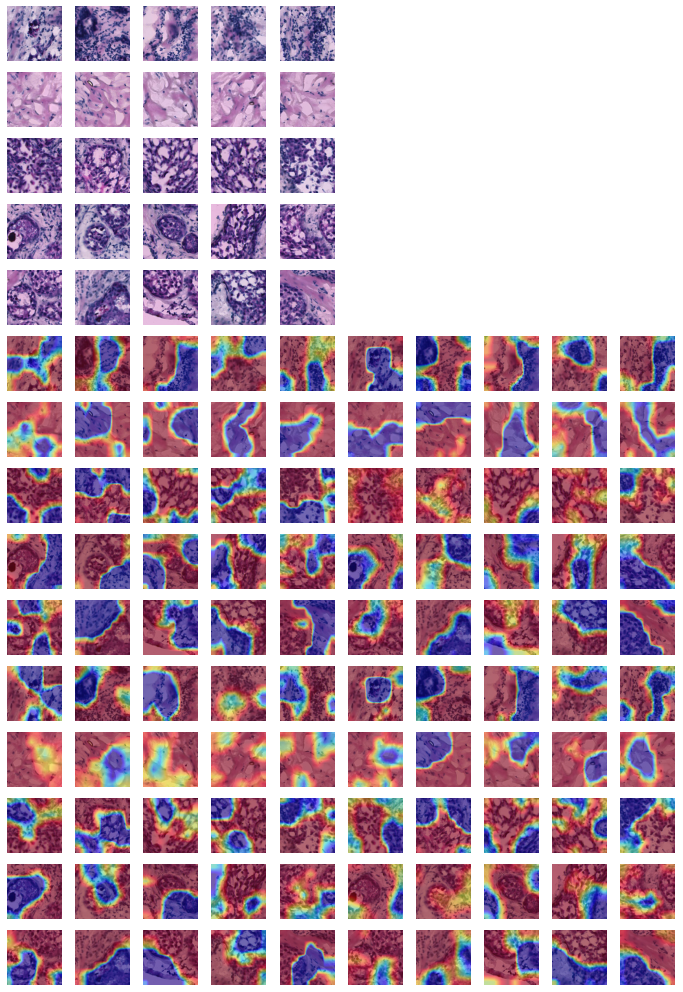

In [23]:
# np.random.seed(4302021)
# index_temp = np.random.choice(indexes, 25, replace=False)
classes = np.arange(n_out_features)
target_layer = "layer4"

n = 0
fig, axes = plt.subplots(15, 10, figsize=(12, 18))
for n_row in range(5):
    for n_col in range(5):
        # Images
        index = indexes[index_temp[n]]
        image = image_dict[index]
        image_normalized = np.transpose(normalize(image), (2, 0, 1))
        image_normalized = torch.tensor([image_normalized]).float().to(device)

        """
        Common usage:
        1. Wrap your model with visualization classes defined in grad_cam.py
        2. Run forward() with images
        3. Run backward() with a list of specific classes
        4. Run generate() to export results
        """

        '''
        # =========================================================================
        print("Vanilla Backpropagation:")

        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        for i in [38, 53, 48, 95]:
            bp.backward(ids=ids[:, [i]])
            gradients = bp.generate()

            # Plot results
            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        # Remove all the hook function in the "model"
        bp.remove_hook()

        # =========================================================================
        print("Deconvolution:")

        deconv = Deconvnet(model=model_imagenet)
        _ = deconv.forward(image_normalized)

        for i in [38, 53, 48, 95]:
            deconv.backward(ids=ids[:, [i]])
            gradients = deconv.generate()

            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        deconv.remove_hook()
        '''

        # =========================================================================
        # print("Grad-CAM/Guided Backpropagation/Guided Grad-CAM:")
        
        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        gcam = GradCAM(model=model_imagenet)
        _ = gcam.forward(image_normalized)

        # gbp = GuidedBackPropagation(model=model_imagenet)
        # _ = gbp.forward(image_normalized)
        
        axes[n_row, n_col].imshow(image)
        axes[n_row, n_col].axis('off')

        for _, i in enumerate([38, 53, 48, 95]):
            # Guided Backpropagation
            # gbp.backward(ids=ids[:, [i]])
            # gradients = gbp.generate()

            # Grad-CAM
            gcam.backward(ids=ids[:, [i]])
            regions = gcam.generate(target_layer=target_layer)
            
            # Normalize
            # B, C, H, W = gcam.shape
            # gcam = gcam.view(B, -1)
            # gcam -= gcam.min(dim=1, keepdim=True)[0]
            # gcam /= gcam.max(dim=1, keepdim=True)[0]
            # gcam = gcam.view(B, C, H, W)
            # print(regions.min())
            # print(regions.max())
            regions /= 0.001  # 0.002 looks good

            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                # Guided Backpropagation
                # plot_gradient(gradient=gradients[j])

                # Grad-CAM
                plot_gradcam(gcam=regions[j, 0], raw_image=image, plt=axes[n_row + 5 * (_%2 + 1), n_col + 5 * int(_/2)], 
                            paper_cmap=False)

                # Guided Grad-CAM
                # plot_gradient(gradient=torch.mul(regions, gradients)[j])
                
        n += 1
for _ in axes:
    for _ax in _:
        _ax.axis('off')
plt.show()

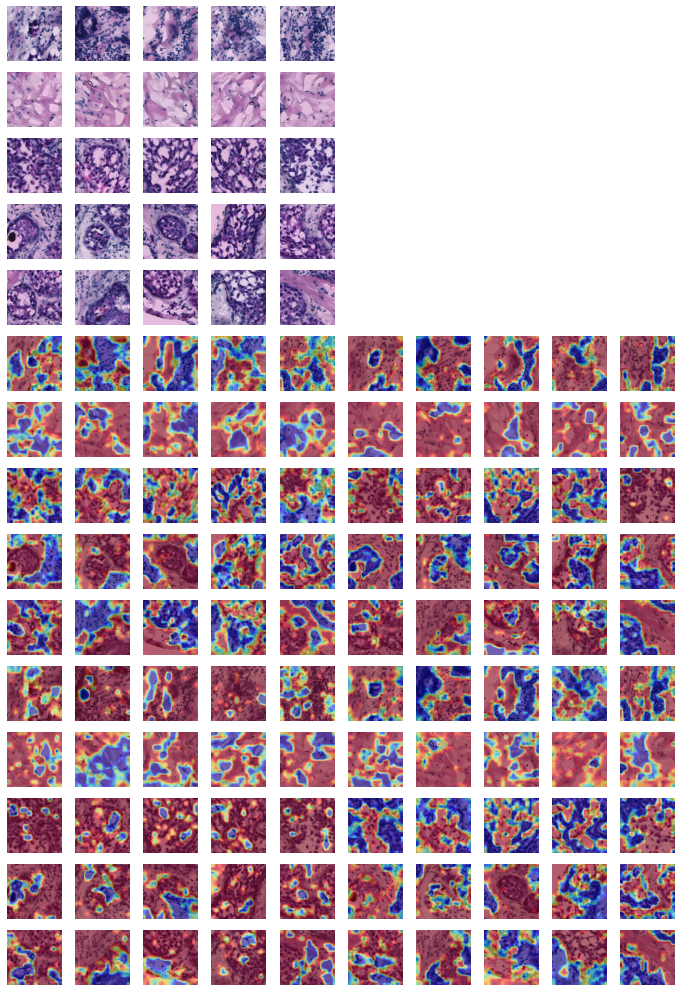

In [22]:
# np.random.seed(4302021)
# index_temp = np.random.choice(indexes, 25, replace=False)
classes = np.arange(n_out_features)
target_layer = "layer3"

n = 0
fig, axes = plt.subplots(15, 10, figsize=(12, 18))
for n_row in range(5):
    for n_col in range(5):
        # Images
        index = indexes[index_temp[n]]
        image = image_dict[index]
        image_normalized = np.transpose(normalize(image), (2, 0, 1))
        image_normalized = torch.tensor([image_normalized]).float().to(device)

        """
        Common usage:
        1. Wrap your model with visualization classes defined in grad_cam.py
        2. Run forward() with images
        3. Run backward() with a list of specific classes
        4. Run generate() to export results
        """

        '''
        # =========================================================================
        print("Vanilla Backpropagation:")

        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        for i in [38, 53, 48, 95]:
            bp.backward(ids=ids[:, [i]])
            gradients = bp.generate()

            # Plot results
            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        # Remove all the hook function in the "model"
        bp.remove_hook()

        # =========================================================================
        print("Deconvolution:")

        deconv = Deconvnet(model=model_imagenet)
        _ = deconv.forward(image_normalized)

        for i in [38, 53, 48, 95]:
            deconv.backward(ids=ids[:, [i]])
            gradients = deconv.generate()

            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        deconv.remove_hook()
        '''

        # =========================================================================
        # print("Grad-CAM/Guided Backpropagation/Guided Grad-CAM:")
        
        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        gcam = GradCAM(model=model_imagenet)
        _ = gcam.forward(image_normalized)

        # gbp = GuidedBackPropagation(model=model_imagenet)
        # _ = gbp.forward(image_normalized)
        
        axes[n_row, n_col].imshow(image)
        axes[n_row, n_col].axis('off')

        for _, i in enumerate([38, 53, 48, 95]):
            # Guided Backpropagation
            # gbp.backward(ids=ids[:, [i]])
            # gradients = gbp.generate()

            # Grad-CAM
            gcam.backward(ids=ids[:, [i]])
            regions = gcam.generate(target_layer=target_layer)
            
            # Normalize
            B, C, H, W = regions.shape
            regions = regions.view(B, -1)
            regions -= regions.min(dim=1, keepdim=True)[0]
            regions /= regions.max(dim=1, keepdim=True)[0]
            regions = regions.view(B, C, H, W)
            # print(regions.min())
            # print(regions.max())
            # regions /= 0.001
            regions = np.clip(regions * 2, 0, 1)

            for j in range(len(image_normalized)):
                # print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                # Guided Backpropagation
                # plot_gradient(gradient=gradients[j])

                # Grad-CAM
                plot_gradcam(gcam=regions[j, 0], raw_image=image, plt=axes[n_row + 5 * (_%2 + 1), n_col + 5 * int(_/2)], 
                            paper_cmap=False)

                # Guided Grad-CAM
                # plot_gradient(gradient=torch.mul(regions, gradients)[j])
                
        n += 1
for _ in axes:
    for _ax in _:
        _ax.axis('off')
plt.show()

Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(0.0003)
tensor(0.)
tensor(0.0004)
tensor(0.)
tensor(0.0003)
tensor(0.)
tensor(0.0005)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(0.0006)
tensor(0.)
tensor(0.0002)
tensor(0.)
tensor(0.0003)
tensor(0.)
tensor(0.0003)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(0.0005)
tensor(0.)
tensor(0.0002)
tensor(0.)
tensor(0.0002)
tensor(0.)
tensor(0.0004)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(0.0002)
tensor(0.)
tensor(9.5849e-05)
tensor(0.)
tensor(0.0003)
tensor(0.)
tensor(0.0003)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(0.0003)
tensor(0.)
tensor(0.0003)
tensor(0.)
tensor(0.0003)
tensor(0.)
tensor(0.0002)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(0.0006)
tensor(0.)
tensor(5.0972e-05)
tensor(0.)
tensor(0.0006)
tensor(0.)
tensor(0.0006)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(0.0003)

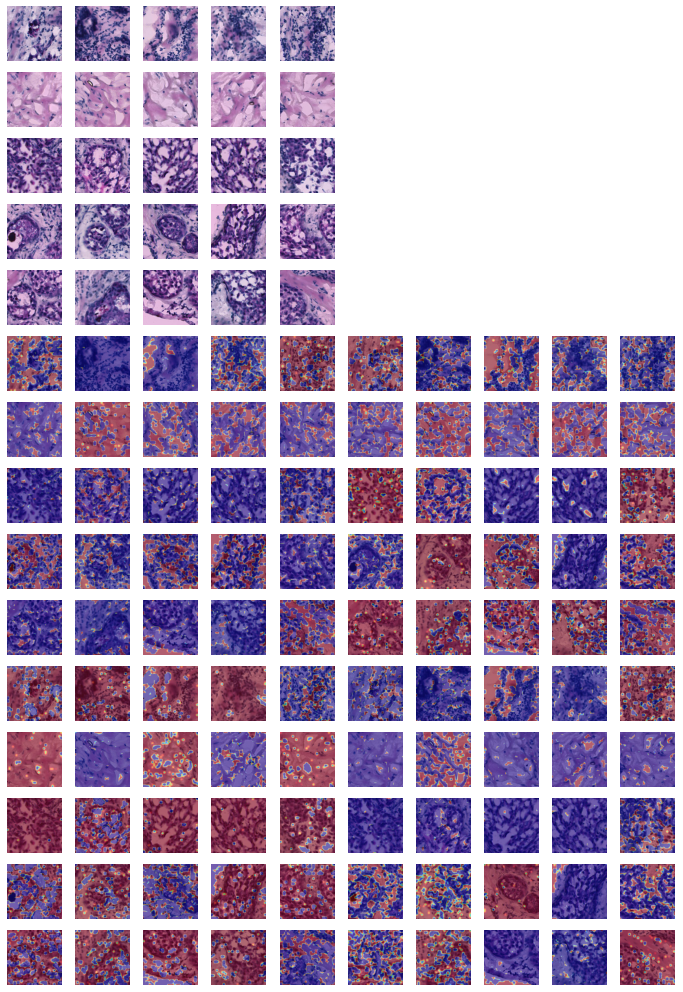

In [16]:
# np.random.seed(4302021)
# index_temp = np.random.choice(indexes, 25, replace=False)
classes = np.arange(n_out_features)
target_layer = "layer2"

n = 0
fig, axes = plt.subplots(15, 10, figsize=(12, 18))
for n_row in range(5):
    for n_col in range(5):
        # Images
        index = indexes[index_temp[n]]
        image = image_dict[index]
        image_normalized = np.transpose(normalize(image), (2, 0, 1))
        image_normalized = torch.tensor([image_normalized]).float().to(device)

        """
        Common usage:
        1. Wrap your model with visualization classes defined in grad_cam.py
        2. Run forward() with images
        3. Run backward() with a list of specific classes
        4. Run generate() to export results
        """

        '''
        # =========================================================================
        print("Vanilla Backpropagation:")

        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        for i in [38, 53, 48, 95]:
            bp.backward(ids=ids[:, [i]])
            gradients = bp.generate()

            # Plot results
            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        # Remove all the hook function in the "model"
        bp.remove_hook()

        # =========================================================================
        print("Deconvolution:")

        deconv = Deconvnet(model=model_imagenet)
        _ = deconv.forward(image_normalized)

        for i in [38, 53, 48, 95]:
            deconv.backward(ids=ids[:, [i]])
            gradients = deconv.generate()

            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        deconv.remove_hook()
        '''

        # =========================================================================
        print("Grad-CAM/Guided Backpropagation/Guided Grad-CAM:")
        
        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        gcam = GradCAM(model=model_imagenet)
        _ = gcam.forward(image_normalized)

        # gbp = GuidedBackPropagation(model=model_imagenet)
        # _ = gbp.forward(image_normalized)
        
        axes[n_row, n_col].imshow(image)
        axes[n_row, n_col].axis('off')

        for _, i in enumerate([38, 53, 48, 95]):
            # Guided Backpropagation
            # gbp.backward(ids=ids[:, [i]])
            # gradients = gbp.generate()

            # Grad-CAM
            gcam.backward(ids=ids[:, [i]])
            regions = gcam.generate(target_layer=target_layer)
            
            # Normalize
            print(regions.min())
            print(regions.max())
            # B, C, H, W = regions.shape
            # regions = regions.view(B, -1)
            # regions -= regions.min(dim=1, keepdim=True)[0]
            # regions /= regions.max(dim=1, keepdim=True)[0]
            # regions = regions.view(B, C, H, W)
            regions /= 0.00002

            for j in range(len(image_normalized)):
                # print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                # Guided Backpropagation
                # plot_gradient(gradient=gradients[j])

                # Grad-CAM
                plot_gradcam(gcam=regions[j, 0], raw_image=image, plt=axes[n_row + 5 * (_%2 + 1), n_col + 5 * int(_/2)])

                # Guided Grad-CAM
                # plot_gradient(gradient=torch.mul(regions, gradients)[j])
                
        n += 1
for _ in axes:
    for _ax in _:
        _ax.axis('off')
plt.show()

Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(7.2234e-05)
tensor(0.)
tensor(3.4359e-05)
tensor(0.)
tensor(6.6786e-05)
tensor(0.)
tensor(5.9233e-05)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(1.1750e-05)
tensor(0.)
tensor(4.5970e-05)
tensor(0.)
tensor(3.1522e-05)
tensor(0.)
tensor(1.4691e-05)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(6.1838e-05)
tensor(0.)
tensor(2.1619e-05)
tensor(2.2342e-07)
tensor(5.7203e-05)
tensor(0.)
tensor(8.6540e-05)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(3.0941e-05)
tensor(0.)
tensor(2.1825e-05)
tensor(4.0451e-07)
tensor(3.5145e-05)
tensor(0.)
tensor(1.6940e-05)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(6.5101e-05)
tensor(0.)
tensor(3.0598e-05)
tensor(0.)
tensor(3.7603e-05)
tensor(0.)
tensor(4.2947e-05)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
tensor(0.)
tensor(2.1021e-05)
tensor(0.)
tensor(1.8321e-05)
tensor(0.)
tensor(7.0955e-05)


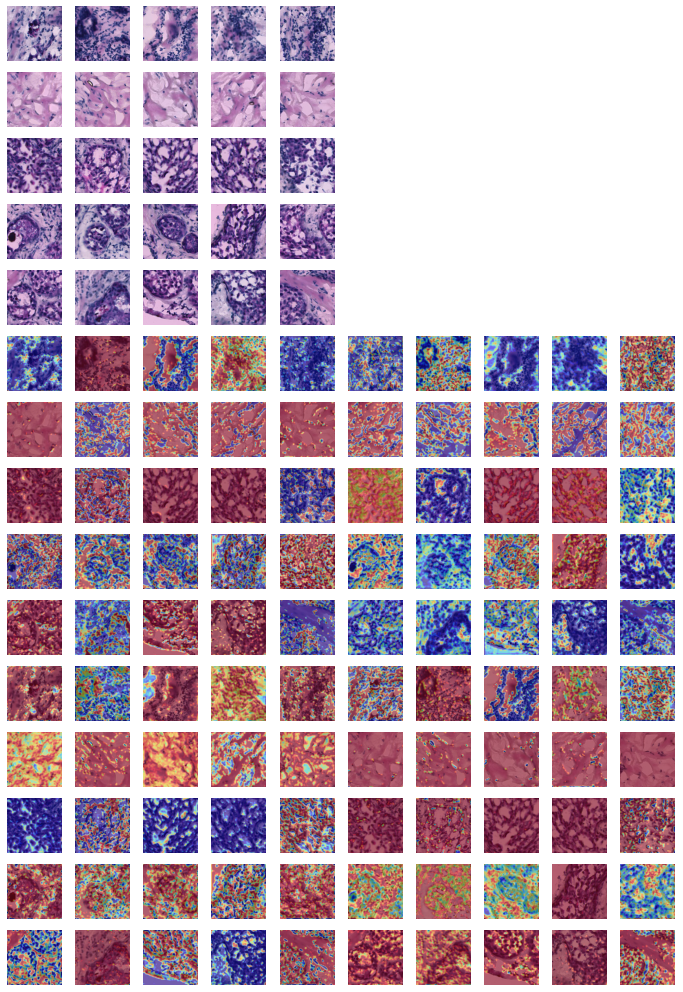

In [17]:
# np.random.seed(4302021)
# index_temp = np.random.choice(indexes, 25, replace=False)
classes = np.arange(n_out_features)
target_layer = "layer1"

n = 0
fig, axes = plt.subplots(15, 10, figsize=(12, 18))
for n_row in range(5):
    for n_col in range(5):
        # Images
        index = indexes[index_temp[n]]
        image = image_dict[index]
        image_normalized = np.transpose(normalize(image), (2, 0, 1))
        image_normalized = torch.tensor([image_normalized]).float().to(device)

        """
        Common usage:
        1. Wrap your model with visualization classes defined in grad_cam.py
        2. Run forward() with images
        3. Run backward() with a list of specific classes
        4. Run generate() to export results
        """

        '''
        # =========================================================================
        print("Vanilla Backpropagation:")

        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        for i in [38, 53, 48, 95]:
            bp.backward(ids=ids[:, [i]])
            gradients = bp.generate()

            # Plot results
            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        # Remove all the hook function in the "model"
        bp.remove_hook()

        # =========================================================================
        print("Deconvolution:")

        deconv = Deconvnet(model=model_imagenet)
        _ = deconv.forward(image_normalized)

        for i in [38, 53, 48, 95]:
            deconv.backward(ids=ids[:, [i]])
            gradients = deconv.generate()

            for j in range(len(image_normalized)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                plot_gradient(gradient=gradients[j])

        deconv.remove_hook()
        '''

        # =========================================================================
        print("Grad-CAM/Guided Backpropagation/Guided Grad-CAM:")
        
        bp = BackPropagation(model=model_imagenet)
        probs, ids = bp.forward(image_normalized)  # sorted

        gcam = GradCAM(model=model_imagenet)
        _ = gcam.forward(image_normalized)

        # gbp = GuidedBackPropagation(model=model_imagenet)
        # _ = gbp.forward(image_normalized)
        
        axes[n_row, n_col].imshow(image)
        axes[n_row, n_col].axis('off')

        for _, i in enumerate([38, 53, 48, 95]):
            # Guided Backpropagation
            # gbp.backward(ids=ids[:, [i]])
            # gradients = gbp.generate()

            # Grad-CAM
            gcam.backward(ids=ids[:, [i]])
            regions = gcam.generate(target_layer=target_layer)
            
            # Normalize
            print(regions.min())
            print(regions.max())
            # B, C, H, W = regions.shape
            # regions = regions.view(B, -1)
            # regions -= regions.min(dim=1, keepdim=True)[0]
            # regions /= regions.max(dim=1, keepdim=True)[0]
            # regions = regions.view(B, C, H, W)
            regions /= 0.00002

            for j in range(len(image_normalized)):
                # print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                # Guided Backpropagation
                # plot_gradient(gradient=gradients[j])

                # Grad-CAM
                plot_gradcam(gcam=regions[j, 0], raw_image=image, plt=axes[n_row + 5 * (_%2 + 1), n_col + 5 * int(_/2)])

                # Guided Grad-CAM
                # plot_gradient(gradient=torch.mul(regions, gradients)[j])
                
        n += 1
for _ in axes:
    for _ax in _:
        _ax.axis('off')
plt.show()

# SessionInfo

In [18]:
!pip freeze

absl-py==0.7.0
altair==3.2.0
anndata==0.7.5
argh==0.26.2
ase==3.21.1
astor==0.7.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.2
backcall==0.1.0
base58==1.0.3
bleach==1.5.0
blinker==1.4
boto3==1.10.15
botocore==1.13.15
Bottleneck==1.2.1
cachetools==4.1.0
certifi==2019.3.9
chardet==3.0.4
Click==7.0
cvxopt==1.2.3
cvxpy==1.0.24
cycler==0.10.0
Cython==0.29.15
dataclasses==0.8
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
docutils==0.15.2
ecos==2.0.7.post1
entrypoints==0.3
enum-compat==0.0.3
environment-kernels==1.1.1
FITS-tools==0.2
future==0.17.1
gast==0.2.2
get-version==2.1
google-auth==1.14.3
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
googledrivedownloader==0.4
grpcio==1.29.0
h5py==2.10.0
html5lib==0.9999999
idna==2.8
image-registration==0.2.4
imageio==2.6.1
importlib-metadata==0.23
ipykernel==5.1.0
ipython==7.4.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
isodate==0.6.0
jedi==0.13.3
Jinja2==2.10.1
jmespath==0.9.4
joblib==1.0.1
jsonschema==3.0.1
jupyter==1.0.0
jupyt